<a href="https://colab.research.google.com/github/allefbcc/cienciaDeDados/blob/main/%5BPET%5D%202%C2%B0%20Fase/%5BPET%5D_%C3%81llef_Robson_Atividade_03_2%C2%B0_Fase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

from sklearn.neighbors import KNeighborsRegressor

In [ ]:
path = 'https://raw.githubusercontent.com/allefbcc/cienciaDeDados/main/Gold%20Price.csv'
dados = pd.read_csv(path)

In [ ]:
dados

In [ ]:
dados['Date'] = pd.to_datetime(dados['Date'])

In [ ]:
dados.info()

In [ ]:
dados = dados.set_index('Date')

In [ ]:
plt.figure(figsize = (16, 8))
dados['Price'].plot()

In [ ]:
train = dados['Price'].loc[:'2018']
val = dados['Price'].loc['2019':'2020']
test = dados['Price'].loc['2021':]

In [ ]:
plt.figure(figsize=(16, 8))

plt.plot(train, label='Train Price', color='blue')
plt.plot(val, label='Validation Price', color='green')
plt.plot(test, label='Test Price', color='orange')

plt.title('Price Train/Validation/Test Data')
plt.xlabel('Date')
plt.ylabel('Value')

plt.legend(loc='best')

plt.show()

In [ ]:
def acf_pacf(data, qtd_lag, title):

  #data = data.resample('M').mean()

  fig = plt.figure(figsize=(16, 10))


  ax1 = fig.add_subplot(221)
  sm.graphics.tsa.plot_acf(data, lags=qtd_lag, ax=ax1)
  #ax1.set_title(f'ACF ({title}) - Monthly')
  ax1.set_title(f'ACF ({title}) - Diary')

  ax2 = fig.add_subplot(222)
  sm.graphics.tsa.plot_pacf(data, lags=qtd_lag, ax=ax2)
  #ax2.set_title(f'PACF ({title}) - Monthly')
  ax2.set_title(f'PACF ({title}) - Diary')

  plt.tight_layout()
  plt.show()


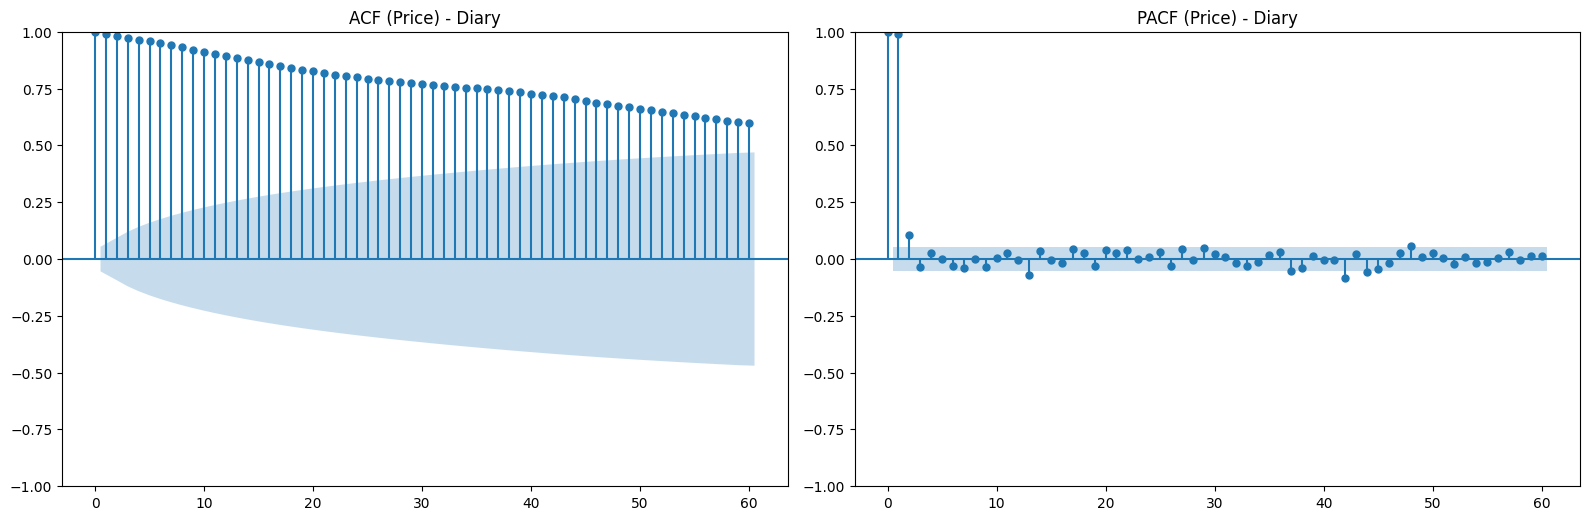

In [ ]:
acf_pacf(train, 60, 'Price')

In [ ]:
def create_sliding_windows(series, window_size):

    list_of_sliding_windows = []
    list_size_to_iterate = len(series) - window_size
    for i in range(0, list_size_to_iterate):
        window = series[i: i + window_size + 1]
        list_of_sliding_windows.append(window)

    return np.array(list_of_sliding_windows).reshape(len(list_of_sliding_windows), window_size+1)

In [ ]:
train.head(10)

Date
2014-01-01    29542
2014-01-02    29975
2014-01-03    29727
2014-01-04    29279
2014-01-06    29119
2014-01-07    28959
2014-01-08    28934
2014-01-09    28997
2014-01-10    29169
2014-01-13    29312
Name: Price, dtype: int64

In [ ]:
train_windows = create_sliding_windows(train, 4)
val_windows = create_sliding_windows(val, 4)
test_windows = create_sliding_windows(test, 4)

In [ ]:
train_windows

array([[29542, 29975, 29727, 29279, 29119],
       [29975, 29727, 29279, 29119, 28959],
       [29727, 29279, 29119, 28959, 28934],
       ...,
       [31219, 31126, 31375, 31463, 31611],
       [31126, 31375, 31463, 31611, 31506],
       [31375, 31463, 31611, 31506, 31489]])

In [ ]:
X_train = train_windows[:, 0:-1]
y_train = train_windows[:, -1]

X_val = val_windows[: ,0: -1]
y_val = val_windows[: , -1 ]

X_test = test_windows[: ,0: -1]
y_test = test_windows[: , -1 ]

In [ ]:
X_train

array([[29542, 29975, 29727, 29279],
       [29975, 29727, 29279, 29119],
       [29727, 29279, 29119, 28959],
       ...,
       [31219, 31126, 31375, 31463],
       [31126, 31375, 31463, 31611],
       [31375, 31463, 31611, 31506]])

### Decision Tree

In [ ]:
criterio = ['squared_error', 'friedman_mse', 'absolute_error']

mse_best_dt = np.inf
best_param_dt = None

for c in criterio:
  modelo_dt = DecisionTreeRegressor(criterion=c)
  modelo_dt.fit(X_train, y_train)
  prev_val_dt = modelo_dt.predict(X_val)

  mse_val_dt = MSE(y_val, prev_val_dt)
  if mse_val_dt < mse_best_dt:
    mse_best_dt = mse_val_dt
    best_param_dt = c

In [ ]:
mse_best_dt

165961542.78669277

In [ ]:
best_param_dt

'friedman_mse'

In [ ]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

In [ ]:
modelo_dt = DecisionTreeRegressor(criterion=best_param_dt)
modelo_dt.fit(X_train_full, y_train_full)
prev_train_dt = modelo_dt.predict(X_train_full)

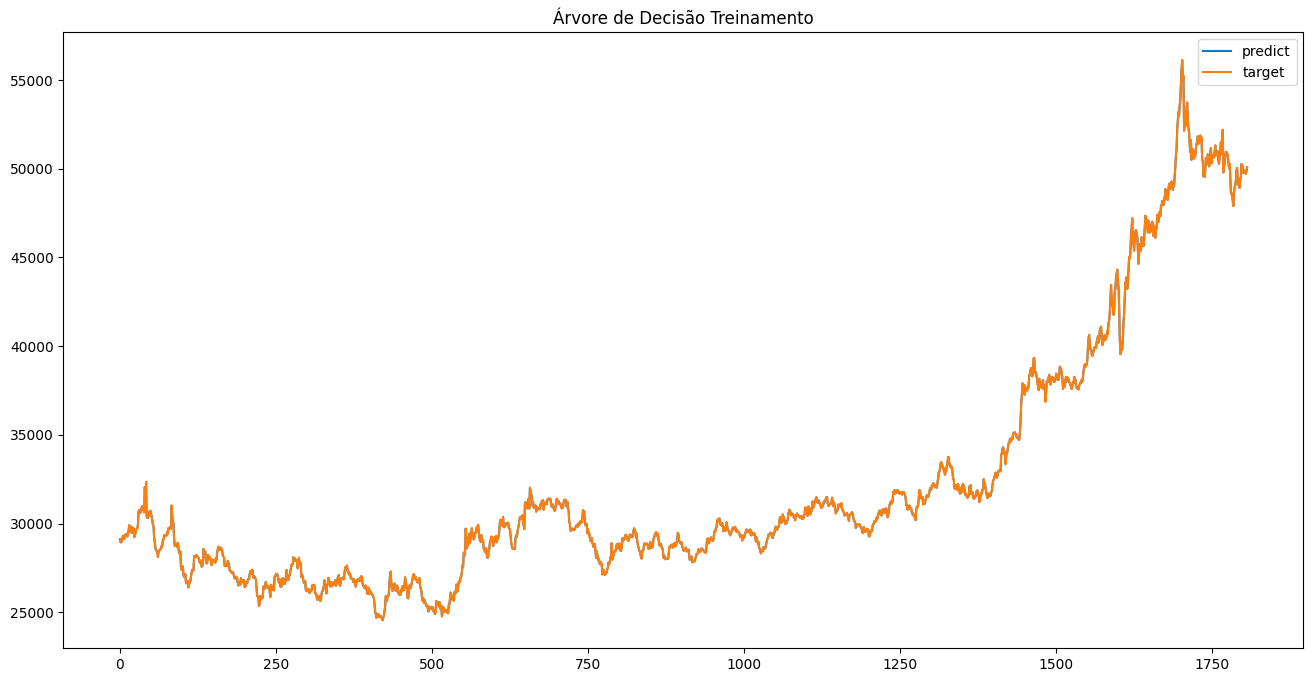

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Árvore de Decisão Treinamento')
plt.plot(prev_train_dt, label = 'predict')
plt.plot(y_train_full, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [ ]:
MSE(y_train_full, prev_train_dt)

0.0

In [ ]:
prev_test_dt = modelo_dt.predict(X_test)

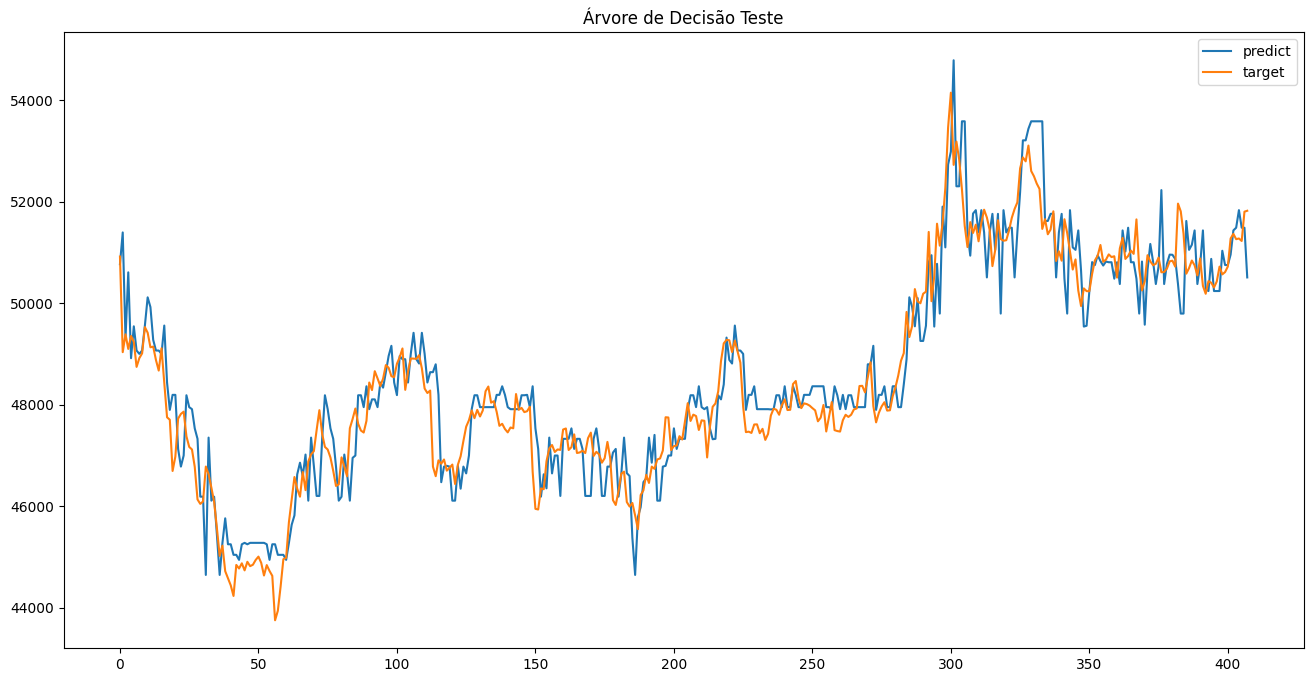

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Árvore de Decisão Teste')
plt.plot(prev_test_dt, label = 'predict')
plt.plot(y_test, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [ ]:
MSE(y_test, prev_test_dt)

453850.8799019608

### KNN

In [ ]:
algoritmo = ['auto', 'ball_tree', 'kd_tree', 'brute']

mse_best_knn = np.inf
best_param_knn = None

for k in algoritmo:

  modelo_knn = KNeighborsRegressor(algorithm=k)
  modelo_knn.fit(X_train, y_train)
  prev_val_knn = modelo_knn.predict(X_val)

  mse_val_knn = MSE(y_val, prev_val_knn)

  if mse_val_knn < mse_best_knn:
    mse_best_knn = mse_val_knn
    best_param_knn = k

In [ ]:
mse_best_knn

139480220.99679065

In [ ]:
best_param_knn

'auto'

In [ ]:
modelo_knn = KNeighborsRegressor(algorithm=best_param_knn)
modelo_knn.fit(X_train_full, y_train_full)
prev_train_knn = modelo_knn.predict(X_train_full)

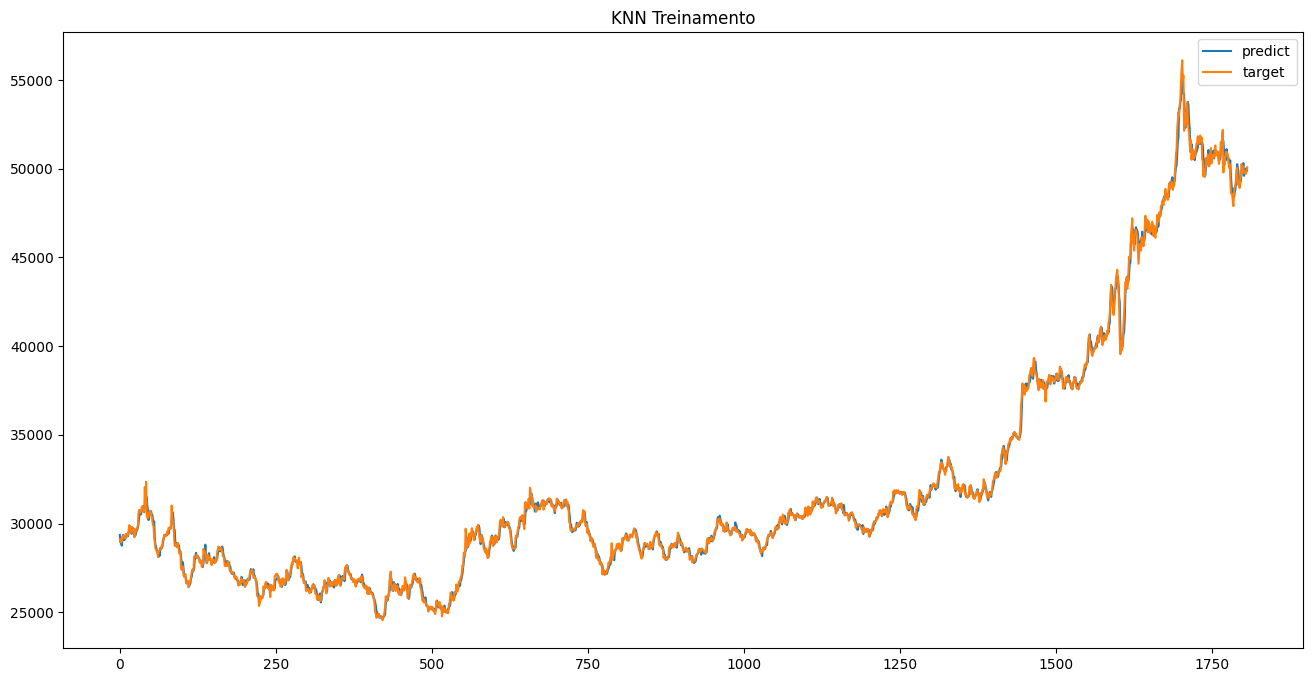

In [ ]:
plt.figure(figsize=(16, 8))
plt.title('KNN Treinamento')
plt.plot(prev_train_knn, label = 'predict')
plt.plot(y_train_full, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [ ]:
MSE(y_train_full, prev_train_knn)

81585.4920199225

In [ ]:
prev_test_knn = modelo_knn.predict(X_test)

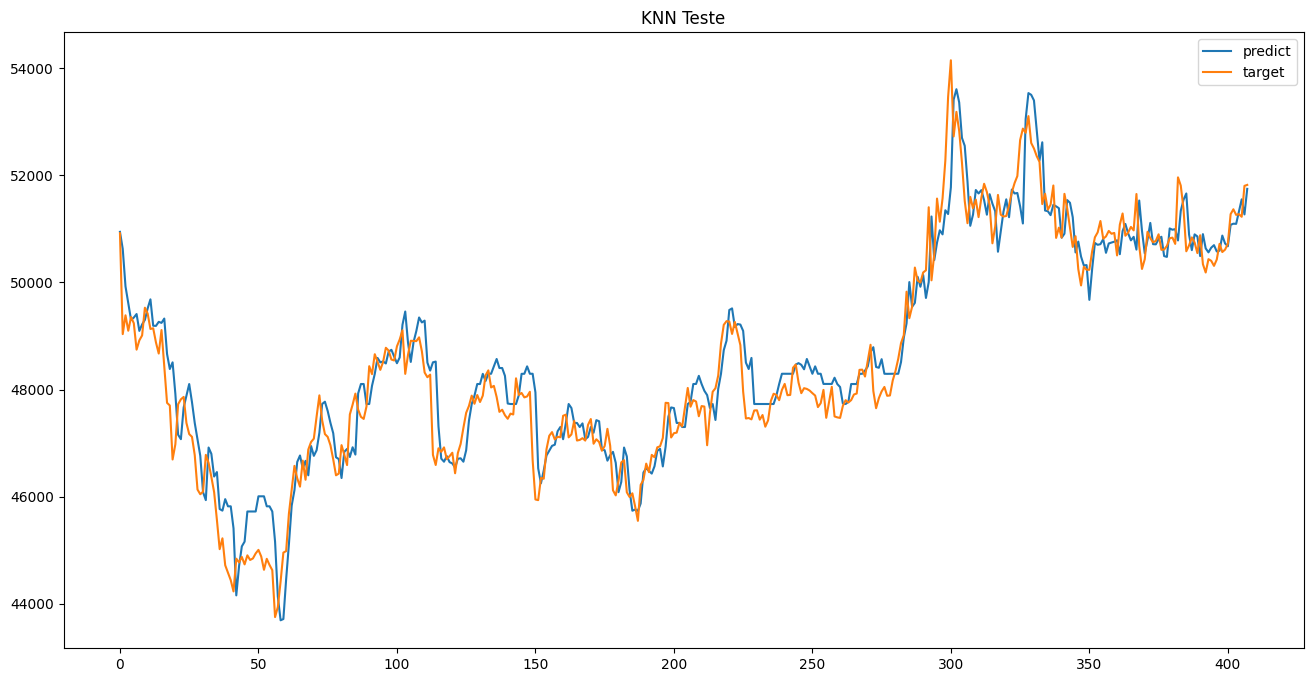

In [ ]:
plt.figure(figsize=(16, 8))
plt.title('KNN Teste')
plt.plot(prev_test_knn, label = 'predict')
plt.plot(y_test, label = 'target')
plt.legend(loc = 'best')
plt.show()

In [ ]:
MSE(y_test, prev_test_knn)

329463.5749019606